# CNNs avec Keras sur des données de paysage

## Vérification de l'utilisation de GPU et import dataset

Allez dans le menu `Exécution > Modifier le type d'execution` et vérifiez que l'on est bien en Python 3 et que l'accélérateur matériel est configuré sur « GPU ».

In [ ]:
'''
!git clone -b dev-rose https://github.com/Finweto/Projet-deep-learning-2022.git
!ls
'''

In [2]:
# !nvidia-smi

## Import des librairies nécessaires

In [2]:
import itertools
import os
import pathlib
import random
import typing
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
'''
import seaborn
import sklearn.utils
import sklearn.metrics
'''
import tensorflow as tf
import keras

2022-12-04 19:12:36.513407: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/cytech/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-12-04 19:12:36.513431: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Préparation des données


Après avoir chargé chaque image, nous allons passer leur canaux en RGB puis les redimensionner à 150x150, enfin, par défaut, nous retournerons un dataset mélangé grâce à [`sklearn.utils.shuffle`](https://scikit-learn.org/stable/modules/generated/sklearn.utils.shuffle.html).


In [3]:
label_names = ["convolvulaceae","monimiaceae","amborella","castanea","desmodium","eugenia",
              "laurus","litsea","magnolia","rubus","ulmus"]

def get_images(filename):

  df=pd.read_csv(filename)
  df=df.sample(frac=1).reset_index(drop=True)

  images = []
  labels = []

  for i in range(len(df["label"])):
    path=df["img_path"][i]

    image=cv2.imread(path)
    image=cv2.resize(image,(150,150))
    images.append(image)

    label=df["label"][i]
    labels.append(label)

  return images,labels

label_to_index = {l: i for i, l in enumerate(label_names)}

## Appel à `get_images`

In [4]:
images, labels= get_images("./data_train_labeled.csv")
images_test,labels_test=get_images("./data_test_labeled.csv")

### validation split (optionnal here because we have the same distribution of labels)

In [ ]:
from sklearn.model_selection import train_test_split

images, images_validation, labels, labels_validation = train_test_split(images, labels, stratify=labels, test_size=0.3) # before model building

### Affichage des labels

In [ ]:
seaborn.countplot(x=labels)
plt.title("Décomptes des différents labels")
plt.ylabel("Décompte")
plt.xlabel("Label")
plt.show()

### Affichage d'exemples d'images

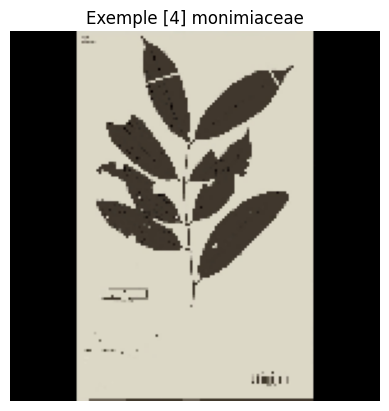

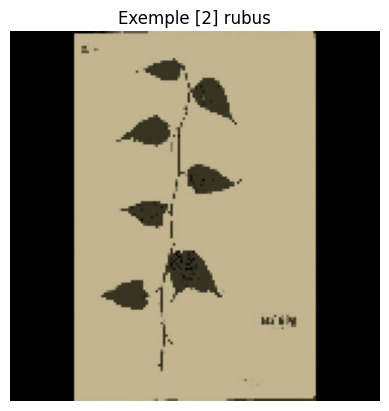

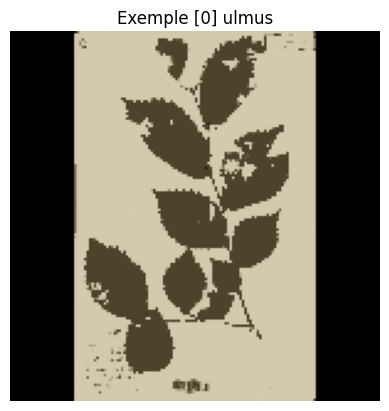

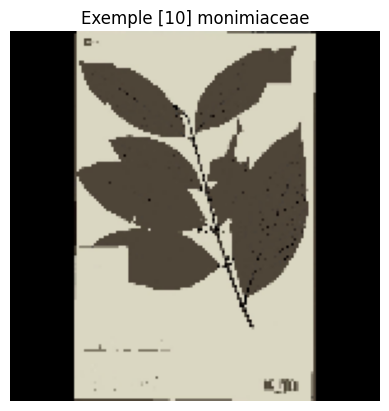

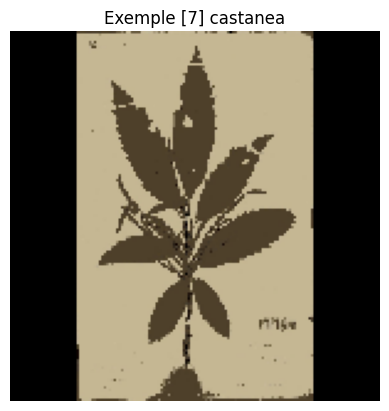

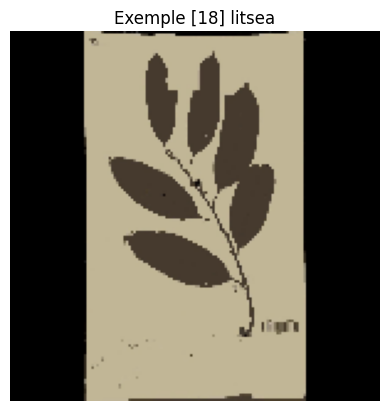

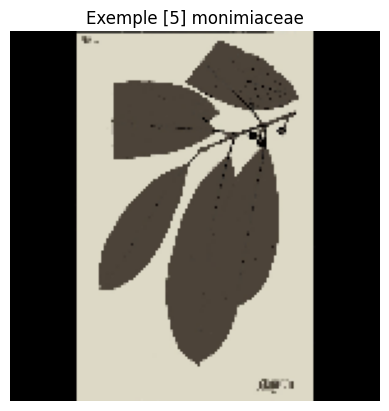

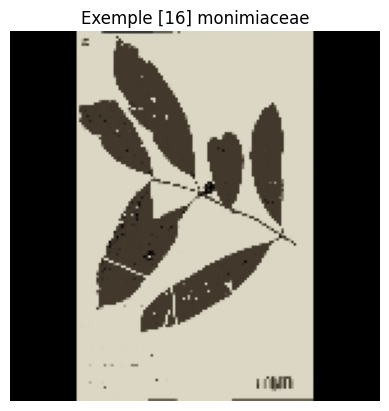

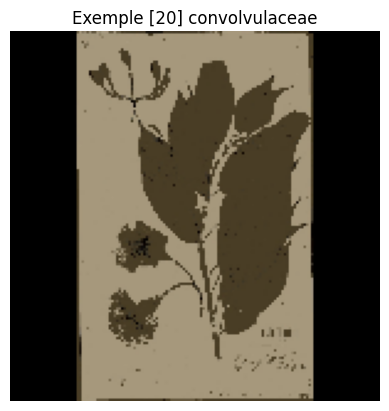

In [5]:
import random

# generation d'index aleatoires
random_indexes = []
for i in range(15):
  random_index = random.randint(0,20)
  if (random_index not in random_indexes):
    random_indexes.append(random_index)

# affichage d'exemples d'images et de leur label

for i in range(1,len(random_indexes)):
  plt.figure()
  random_index= random_indexes[i]
  plt.imshow(images[random_index])
  plt.title('Exemple ['+str(random_index)+'] '+labels[random_index])
  plt.axis('off')
 
plt.show() 




## Data Augmentation (TO DO work in progress nathan)

#### Pré traitement de la data


In [7]:
images=np.array(images)
labels=np.array(labels)

images_test=np.array(images_test)
labels_test=np.array(labels_test)

# images_validation=np.array(images_validation)
# labels_validation=np.array(labels_validation)

labels_int=[label_names.index(x) for x in labels]
labels_int=np.array(labels_int)

labels_test_int=[label_names.index(x) for x in labels_test]
labels_test_int=np.array(labels_test_int)

# labels_validation_int=[label_names.index(x) for x in labels_validation]
# labels_validation_int=np.array(labels_validation_int)

In [8]:
from keras.preprocessing.image import ImageDataGenerator

def vertical_shift(images):
  # creation image data augmentation generator width_shift (vertical shift)
  datagen = ImageDataGenerator(width_shift_range=0.2)
  # creation of the images
  vertical_shift_images = datagen.flow(images, batch_size=1)

  return vertical_shift_images

def horizontal_shift(images):
  # creation image data augmentation generator height_shift (horizontal shift)
  datagen = ImageDataGenerator(height_shift_range=0.2)

  # creation of the images
  horizontal_shift_images = datagen.flow(images,batch_size=1)

  return horizontal_shift_images

def horizontal_flip(images):
  # creation image data augmentation generator horizontal_flip
  datagen = ImageDataGenerator(horizontal_flip=True)

  # creation of the images
  horizontal_flip_images = datagen.flow(images,batch_size=1)

  return horizontal_flip_images

def vertical_flip(images):
  # creation image data augmentation generator vertical_flip
  datagen = ImageDataGenerator(vertical_flip=True)

  # creation of the images
  vertical_flip_images = datagen.flow(images,batch_size=1)

  return vertical_flip_images

def rotation_change(images):
  # creation image data augmentation generator rotation_change
  datagen = ImageDataGenerator(rotation_range=50)

  # creation of the images
  rotation_images = datagen.flow(images,batch_size=1)

  return rotation_images

def brightness_change(images):
  # creation image data augmentation generator brightness_change
  datagen = ImageDataGenerator(brightness_range=[0.15,2.0])

  # creation of the images
  brightness_images = datagen.flow(images, batch_size=1)

  return brightness_images
  

In [9]:
# fonction taking our images and labels, returning modified images with corresponding labels for our lack of data
def imageAugmentation(images):
  augmented_images = []
  temp = []

  # temp.append(vertical_shift(images))
  temp=vertical_shift(images)

  #temp.append(horizontal_shift(images))
  #temp.append(horizontal_flip(images))
  #temp.append(vertical_flip(images))
  #temp.append(rotation_change(images))
  #temp.append(brightness_change(images))

  '''
  for results in temp:
    for elem in results:
      augmented_images.append(elem)
  '''
  for elem in temp:
    augmented_images.append(elem)
  
  return augmented_images




In [10]:
augmented_images = imageAugmentation(images)


[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]]


: 

: 

In [ ]:
for augmented_image in augmented_images:
  np.append(images, augmented_image)

labels = np.concatenate((labels,labels))

In [ ]:
tab = np.array([1,2,3])
tab = tab*2

## Apprentissage

#### Metrics

In [ ]:
# Plot des métriques d'entraînement
def plot_metrics(history) -> None:
  plt.plot(training.history["acc"])
  #plt.plot(training.history["val_accuracy"])
  plt.title("Accuracy du modèle")
  plt.ylabel("Accuracy")
  plt.xlabel("Epoch")
  plt.legend(["Entraînement", "Validation"], loc="upper left")
  plt.show()

  plt.plot(training.history["loss"])
  plt.plot(training.history["val_loss"])
  plt.title("Perte du modèle")
  plt.ylabel("Perte")
  plt.xlabel("Epoch")
  plt.legend(["Entraînement", "Validation"], loc="upper right")
  plt.show()


#### Modèle 1

In [ ]:
from keras import layers as layer
# Le modèle
model = keras.models.Sequential()
model.add(layer.Conv2D(128,3,activation='relu',input_shape=(200,200,3)))
model.add(layer.Conv2D(64,3,activation='relu'))
model.add(layer.Conv2D(32,3,activation='relu'))
model.add(layer.MaxPooling2D(3))
model.add(layer.Dropout(0.2))

model.add(layer.Conv2D(128,3,activation='relu'))
model.add(layer.Conv2D(64,3,activation='relu'))
model.add(layer.Conv2D(32,3,activation='relu'))
model.add(layer.MaxPooling2D(3))
model.add(layer.Dropout(0.2))

model.add(layer.Conv2D(128,3,activation='relu'))
model.add(layer.Conv2D(64,3,activation='relu'))
model.add(layer.Conv2D(32,3,activation='relu'))
model.add(layer.MaxPooling2D(3))
model.add(layer.Dropout(0.2))

model.add(layer.Flatten())

model.add(layer.Dense(512, activation='relu'))
model.add(layer.Dropout(0.4))

model.add(layer.Dense(11, activation="softmax"))

# Compilation du modèle
model.compile(
    loss="sparse_categorical_crossentropy",
    metrics=['acc'],
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
)

# Sommaire du modèle
model.summary()

#### Entrainement du modèle

In [ ]:
# Apprentissage du modèle
training = model.fit(images,
                     labels_int,
                     epochs=20,
                     validation_split=0.30,
                     #validation_data=(images_validation, labels_validation_int),
                     batch_size=8,
                     shuffle=True)

# Visualisation des métriques d'entrainement
plot_metrics(training.history)

## Évaluation des performances sur l'ensemble de test

Dans le dossier `seg_test` se trouve un ensemble de données qui n'ont jamais été vues durant l'apprentissage.

On utilisera la méthode `evaluate(X, y)` du modèle pour évaluer la qualité de nos prédictions sur ce dataset.

In [ ]:
model.evaluate(images_test, labels_test_int, verbose=1)

## Analyse d'erreur

On affiche la matrice de confusion puis on regarde des images mal classées.

In [ ]:
def analyze_preds(preds, labels):
  confusion_matrix = sklearn.metrics.confusion_matrix(preds,
                                                      labels,
                                                      normalize="true")
  seaborn.heatmap(confusion_matrix,
                  cmap="rocket_r",
                  xticklabels=label_names,
                  yticklabels=label_names)
  plt.title("Matrice de confusion")
  plt.show()

  seaborn.countplot(x=list(map(lambda x: label_names[x], preds)))
  plt.title("Décomptes des classes prédites")
  plt.ylabel("Décompte")
  plt.xlabel("Class")
  plt.show()


test_pred = np.argmax(model.predict(images_test), axis=-1)
analyze_preds(test_pred, labels_test_int)

## Suite de l'analyze (TO DO)

In [ ]:
def plot_mistakes(predicted_class: str, true_class: str) -> None:
  print(f"Prédiction : {predicted_class}, classe réelle : {true_class}")
  mistakes = images_test[(test_pred == label_to_index[predicted_class])
                         & (labels_test_int == label_to_index[true_class])]
  random_indexes = np.random.choice(mistakes.shape[0],
                                       size=min(mistakes.shape[0], 25),
                                       replace=False)
  grid_indexes = itertools.product(range(5), repeat=2)

  _, ax = plt.subplots(5, 5, figsize=(15, 15))
  for img_index, (i, j) in zip(random_indexes, grid_indexes):
    ax[i, j].imshow(mistakes[img_index])
    ax[i, j].axis("off")
  plt.show()

In [ ]:
# Plot les images prédites glacier alors qu'elles ont un label montagne
plot_mistakes("glacier", "mountain")

In [ ]:
# Plot les images prédites glacier alors qu'elles ont un label mer
plot_mistakes("glacier", "sea")

In [ ]:
# Plot les images prédites bâtiment alors qu'elles ont un label mer
plot_mistakes("buildings", "sea")

## Transfert d'apprentissage

In [ ]:
base_model = keras.applications.EfficientNetB7(include_top=False,
                                               weights="imagenet",
                                               input_shape=(150, 150, 3))

base_model.trainable = False

model = keras.Sequential(
    [base_model,
     keras.layers.SpatialDropout2D(0.1),
     keras.layers.Conv2D(1024, 1, activation="relu"),
     keras.layers.SpatialDropout2D(0.1),
     keras.layers.Conv2D(256, 1, activation="relu"),
     keras.layers.SpatialDropout2D(0.1),
     keras.layers.Conv2D(64, 1, activation="relu"),
     keras.layers.SpatialDropout2D(0.1),
     keras.layers.Conv2D(16, 1, activation="relu"),
     keras.layers.SpatialDropout2D(0.1),
     keras.layers.Flatten(),
     keras.layers.Dense(6, activation="softmax", kernel_regularizer="l2")])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

In [ ]:
training = model.fit(images,
                     labels,
                     epochs=5,
                     validation_split=0.30,
                     batch_size=512)

plot_metrics(training.history)

In [ ]:
model.evaluate(test_images, test_labels, verbose=1)
test_preds = numpy.argmax(model.predict(test_images), axis=-1)
analyze_preds(test_preds, test_labels)
plot_mistakes("glacier", "mountain")
plot_mistakes("glacier", "sea")
plot_mistakes("buildings", "sea")

## Prédire dans des condition « réelles »

Dans le dossier `seg_pred` se trouvent des images non-annotées. On ne peut donc pas évaluer correctement les performances sur cet ensemble. 

Cependant, on peut afficher des photos et les probabilités que notre modèle attribue à chaque classe.

In [ ]:
pred_images, _, pred_file_paths = get_images(
    pathlib.Path("dataset-landscape") / "seg_pred")
pred_images.shape

In [ ]:
# Création de la grille de sous-plots. On donne l'argument figsize pour agrandir
# la taille de la figure qui est petite par défaut
_, ax = plt.subplots(10, 5, figsize=(30, 45))

# On choisit 25 indices au hasard, sans replacement (on ne veut pas afficher la
# même image deux fois)
random_indexes = numpy.random.choice(pred_images.shape[0],
                                     size=(5, 5),
                                     replace=False)

for i in range(5):
  for j in range(5):
    img_index = random_indexes[i, j]
    # Récupération de l'image et prédiction de sa classe
    image = pred_images[img_index]
    probabilities = model.predict(image[None, ...])[0]
    predicted_class = label_names[numpy.argmax(probabilities)]

    # Affichage avec matplotlib et sa fonction imshow, très pratique en vision
    # par ordinateur
    ax[i * 2, j].imshow(image)
    ax[i * 2, j].set_title(f"Exemple {img_index}")
    ax[i * 2, j].axis('off')

    # Affichage de la distribution de prédiction sur la ligne d'en dessous
    ax[i * 2 + 1, j].bar(label_names, probabilities)